# CLIP Embedding Jacobian Analysis

이 노트북은 Stable Diffusion v1.4의 CLIP 모델에 대해, Memorized Prompt와 Non-memorized Prompt의 입력(Embedding)에 대한 출력(Hidden State)의 Jacobian Frobenius Norm ($||J_c||_F$)을 분석합니다.
Hutchinson Estimator를 사용하여 고차원 Jacobian의 Norm을 효율적으로 추정합니다.

In [62]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline
from tqdm import tqdm
import os

# Random Seed Setting
def seed_everything(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. Load Prompts
prompts/sd1_mem.txt와 prompts/sd1_nmem.txt에서 프롬프트 데이터를 불러옵니다.

In [63]:
def load_prompts(file_path):
    with open(file_path, 'r') as f:
        prompts = [line.strip() for line in f.readlines()]
    return prompts

base_path = "/home/gpuadmin/cssin/cond_Jacobian"
mem_prompts_path = os.path.join(base_path, "prompts/sd1_mem.txt")
nmem_prompts_path = os.path.join(base_path, "prompts/sd1_nmem.txt")

mem_prompts = load_prompts(mem_prompts_path)
nmem_prompts = load_prompts(nmem_prompts_path)

print(f"Loaded {len(mem_prompts)} memorized prompts.")
print(f"Loaded {len(nmem_prompts)} non-memorized prompts.")

Loaded 500 memorized prompts.
Loaded 500 non-memorized prompts.


## 2. Load CLIP Model (SD v1.4)
CompVis/stable-diffusion-v1-4의 Text Component를 로드합니다.
**Note:** `transformers` 직접 로드 시 캐시 문제로 에러가 발생할 수 있어, `diffusers`의 `StableDiffusionPipeline`을 통해 로드한 후 컴포넌트를 추출합니다.

In [64]:
model_id = "CompVis/stable-diffusion-v1-4"

print(f"Loading model {model_id} via StableDiffusionPipeline...")
pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)

tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder.to(device)
text_encoder.eval()

torch.cuda.empty_cache()

print("Model loaded successfully via Pipeline.")

Loading model CompVis/stable-diffusion-v1-4 via StableDiffusionPipeline...


/home/gpuadmin/cssin/cond_Jacobian/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model loaded successfully via Pipeline.


## 3. Hutchinson Estimator for Jacobian Norm

Jacobian Matrix $J = \frac{\partial \text{Output}}{\partial \text{Input}}$에 대해 Frobenius Norm $||J||_F$는 다음과 같이 정의됩니다.
$$ ||J||_F^2 = \text{Trace}(J^T J) $$

Hutchinson Estimator를 이용하면 다음과 같이 근사할 수 있습니다.
$$ ||J||_F^2 \approx \mathbb{E}_{u \sim \mathcal{N}(0, I)} [ ||J^T u||^2 ] $$

**Correction:** `CLIPTextModel`의 `forward` 메서드가 `inputs_embeds`를 직접 지원하지 않는 경우(버전 이슈 등)를 대비하여, 내부 모듈(`embeddings`, `encoder`, `final_layer_norm`)을 직접 호출하여 Forward Pass를 구성합니다.

In [80]:
def compute_jacobian_norm(prompt, tokenizer, text_encoder, num_projections=10):
    # Tokenize
    text_input = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    )
    input_ids = text_input.input_ids.to(device)                     # discrete한 값
    # Note: Pipeline ignores attention_mask, so we do too.

    # Get Input Embeddings (Token Embeddings)
    # This layer returns Raw Token Embeddings (without position encoding)
    input_embeddings_layer = text_encoder.get_input_embeddings()
    ref_embedding = pipeline._encode_prompt(prompt, device, 1, False, None)
    x = input_embeddings_layer(input_ids).detach()
    x.requires_grad_(True)                                          # continuous한 값

    # Pre-compute Masks for Manual Forward
    bsz, seq_len = x.shape[:2]
    
    # 1. Causal Mask
    # Manually create causal mask since _build_causal_attention_mask might be missing
    # Lower triangle is 0 (attend), Upper is -inf (mask)
    mask = torch.full((seq_len, seq_len), float("-inf"), device=device, dtype=x.dtype)
    mask = torch.triu(mask, diagonal=1)
    causal_attention_mask = mask.unsqueeze(0).unsqueeze(0).expand(bsz, 1, seq_len, seq_len)

    # 2. Extended Attention Mask (Padding)
    # We explicitly set this to None to match Stable Diffusion Pipeline behavior
    extended_attention_mask = None
    
    sq_norms = []
    
    for _ in range(num_projections):
        # Manual Forward Pass to utilize inputs_embeds
        
        # A. Embeddings (Add Position Embeddings to x)
        # CLIPTextEmbeddings usually accepts inputs_embeds
        hidden_states = text_encoder.text_model.embeddings(inputs_embeds=x)
        
        # B. Encoder
        encoder_outputs = text_encoder.text_model.encoder(
            inputs_embeds=hidden_states,
            attention_mask=extended_attention_mask,
            causal_attention_mask=causal_attention_mask
        )
        
        last_hidden_state = encoder_outputs[0]
        
        # C. Final Layer Norm
        y = text_encoder.text_model.final_layer_norm(last_hidden_state)
        assert torch.equal(y, ref_embedding), "코드 병신됨"
        
        # Sample random vector u in Output space
        u = torch.randn_like(y)
        
        # Compute VJP
        v = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=u,
            create_graph=False,
            retain_graph=False,
            only_inputs=True
        )[0]
        
        norm_sq = torch.sum(v ** 2).item()
        sq_norms.append(norm_sq)
        
    avg_sq_norm = np.mean(sq_norms)
    return np.sqrt(avg_sq_norm)

## 3.1 Debug: Shape Analysis
하나의 프롬프트에 대해 각 단계별 Output Shape를 확인합니다.

In [92]:
print("=== Debug: Shape Analysis for a Single Prompt ===")
# Pick one prompt
test_prompt = mem_prompts[0]
print(f"Test Prompt: '{test_prompt}'")

# 1. Tokenize
text_input = tokenizer(
    test_prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
)
input_ids = text_input.input_ids.to(device)
# attention_mask = text_input.attention_mask.to(device) # Not used
print(f"1. Input Ids Shape: {input_ids.shape}")

# 2. Input Embeddings
input_embeddings_layer = text_encoder.get_input_embeddings()
x = input_embeddings_layer(input_ids).detach()
print(f"2. Input Embeddings (x) Shape: {x.shape}")

# 3. Masks
bsz, seq_len = x.shape[:2]
# Manual Causal Mask
mask = torch.full((seq_len, seq_len), float("-inf"), device=device, dtype=x.dtype)
mask = torch.triu(mask, diagonal=1)
causal_attention_mask = mask.unsqueeze(0).unsqueeze(0).expand(bsz, 1, seq_len, seq_len)

extended_attention_mask = None
print(f"3. Causal Mask Shape: {causal_attention_mask.shape}")

# 4. Embeddings Layer (Positional)
hidden_states = text_encoder.text_model.embeddings(inputs_embeds=x)
print(f"4. Embeddings Layer Output Shape: {hidden_states.shape}")

# 5. Encoder
encoder_outputs = text_encoder.text_model.encoder(
    inputs_embeds=hidden_states,
    attention_mask=extended_attention_mask,
    causal_attention_mask=causal_attention_mask
)
last_hidden_state = encoder_outputs[0]
print(f"5. Encoder Output (Last Hidden State) Shape: {last_hidden_state.shape}")

# 6. Final Layer Norm
y = text_encoder.text_model.final_layer_norm(last_hidden_state)
print(f"6. Final Layer Norm Output (y) Shape: {y.shape}")

print("=== End Debug ===")

print(x.shape)
print(y.shape)

=== Debug: Shape Analysis for a Single Prompt ===
Test Prompt: 'The No Limits Business Woman Podcast'
1. Input Ids Shape: torch.Size([1, 77])
2. Input Embeddings (x) Shape: torch.Size([1, 77, 768])
3. Causal Mask Shape: torch.Size([1, 1, 77, 77])
4. Embeddings Layer Output Shape: torch.Size([1, 77, 768])
5. Encoder Output (Last Hidden State) Shape: torch.Size([1, 77, 768])
6. Final Layer Norm Output (y) Shape: torch.Size([1, 77, 768])
=== End Debug ===
torch.Size([1, 77, 768])
torch.Size([1, 77, 768])


## 3.2 Debug: Output Similarity Check
수동으로 구성한 Forward Pass (`def compute_jacobian_norm` 내 로직)의 결과(`last_hidden_state`)가
일반적인 `text_encoder(input_ids)` 호출 결과와 동일한지 10번 반복하여 검증합니다.

In [83]:
print("=== Debug: Output Similarity Check (10 runs) ===")
# Use the same test_prompt from 3.1
print(f"Test Prompt: '{test_prompt}'")

text_input = tokenizer(
    test_prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
)
input_ids = text_input.input_ids.to(device)
attention_mask = text_input.attention_mask.to(device)

with torch.no_grad():
    # Standard forward pass with attention_mask=None (matching Pipeline)
    ref_outputs = text_encoder(input_ids, attention_mask=None)
    ref_last_hidden_state = ref_outputs.last_hidden_state
    pipeline_embedding = pipeline._encode_prompt(test_prompt, device, 1, False, None)[0]

# 2. Compare with Manual Forward Pass
max_diffs = []
max_diffs_p = []

for i in range(10):
    # Re-implment Manual Logic
    input_embeddings_layer = text_encoder.get_input_embeddings()
    x = input_embeddings_layer(input_ids).detach()
    
    bsz, seq_len = x.shape[:2]
    
    # Manual Causal Mask
    mask = torch.full((seq_len, seq_len), float("-inf"), device=device, dtype=x.dtype)
    mask = torch.triu(mask, diagonal=1)
    causal_attention_mask = mask.unsqueeze(0).unsqueeze(0).expand(bsz, 1, seq_len, seq_len)

    # Extended Attention Mask -> None
    extended_attention_mask = None

    # Manual Forward
    hidden_states = text_encoder.text_model.embeddings(inputs_embeds=x)
    
    encoder_outputs = text_encoder.text_model.encoder(
    inputs_embeds=hidden_states,
    attention_mask=extended_attention_mask,
    causal_attention_mask=causal_attention_mask
    )
    
    manual_last_hidden_state = encoder_outputs[0]
    
    # IMPORTANT: Apply final_layer_norm
    manual_output = text_encoder.text_model.final_layer_norm(manual_last_hidden_state)
    
    # Compute Diff
    diff = torch.abs(manual_output - ref_last_hidden_state).max().item()
    diff_p = torch.abs(manual_output - pipeline_embedding).max().item()
    max_diffs.append(diff)
    max_diffs_p.append(diff_p)
    # print(f"Run {i+1}: Max Diff = {diff}")

print(f"Results over 10 check runs:")
print(f"  Max Difference: {np.max(max_diffs)}")
print(f"  Mean Difference: {np.mean(max_diffs)}")
print(f"  Max Difference Pipeline: {np.max(max_diffs_p)}")
print(f"  Mean Difference Pipeline: {np.mean(max_diffs_p)}")

is_match = np.all(np.array(max_diffs) < 1e-4) # Allow small float error
if is_match:
    print("SUCCESS: Manual forward pass matches target output!")
else:
    print("WARNING: Outputs do NOT match. Check the manual implementation.")
print("=== End Similarity Check ===")

=== Debug: Output Similarity Check (10 runs) ===
Test Prompt: 'The No Limits Business Woman Podcast'
Results over 10 check runs:
  Max Difference: 0.0
  Mean Difference: 0.0
  Max Difference Pipeline: 0.0
  Mean Difference Pipeline: 0.0
SUCCESS: Manual forward pass matches target output!
=== End Similarity Check ===


## 4. Run Analysis
Memorized Prompt와 Non-memorized Prompt에 대해 각각 Jacobian Norm을 계산합니다.

In [85]:
mem_norms = []
nmem_norms = []
n = 10

print("Calculating for Memorized Prompts...")
for prompt in tqdm(mem_prompts[:n]):
    try:
        norm = compute_jacobian_norm(prompt, tokenizer, text_encoder, num_projections=50)
        mem_norms.append(norm)
    except Exception as e:
        print(f"Error processing prompts: {e}")
        break

if len(mem_norms) > 0:
    print(f"Completed {len(mem_norms)} memorized prompts.")
    print("Calculating for Non-memorized Prompts...")
    for prompt in tqdm(nmem_prompts[:n]):
        try:
            norm = compute_jacobian_norm(prompt, tokenizer, text_encoder, num_projections=50)
            nmem_norms.append(norm)
        except Exception as e:
            print(f"Error processing prompts: {e}")
            break

    # Save results
    np.save(os.path.join(base_path, "mem_clip_jnorms.npy"), mem_norms)
    np.save(os.path.join(base_path, "nmem_clip_jnorms.npy"), nmem_norms)
else:
    print("Aborted due to error.")

Calculating for Memorized Prompts...


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


Completed 10 memorized prompts.
Calculating for Non-memorized Prompts...


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


## 5. Visualization
두 그룹 간의 $||J_c||_F$ 분포를 비교합니다.

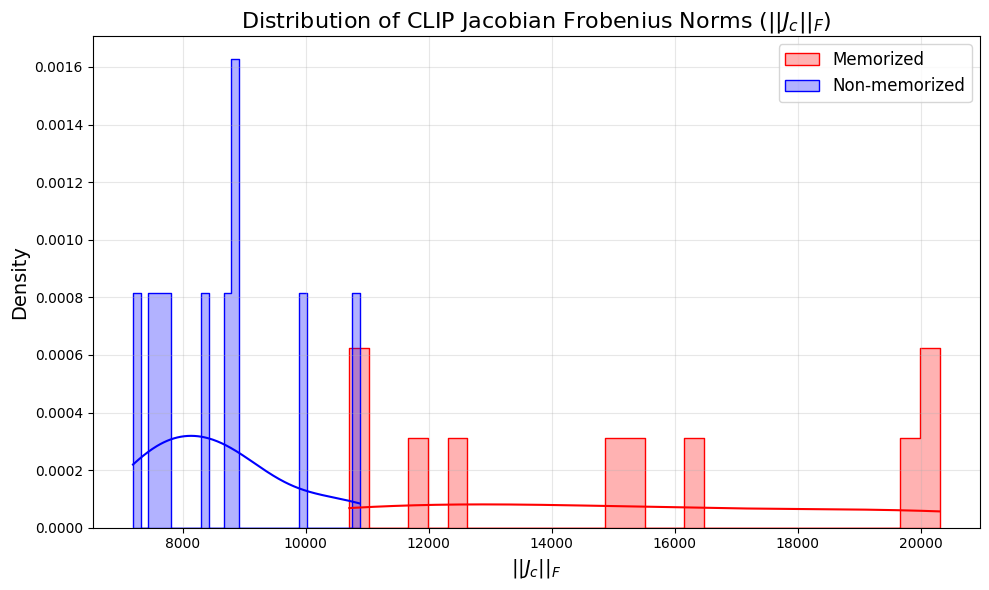

In [90]:
if len(mem_norms) > 0 and len(nmem_norms) > 0:
    plt.figure(figsize=(10, 6))

    # Use histplot instead of kdeplot
    sns.histplot(mem_norms, label='Memorized', color='red', alpha=0.3, element="step", stat="density", kde=True, bins=30)
    sns.histplot(nmem_norms, label='Non-memorized', color='blue', alpha=0.3, element="step", stat="density", kde=True, bins=30)

    plt.title('Distribution of CLIP Jacobian Frobenius Norms ($||J_c||_F$)', fontsize=16)
    plt.xlabel('$||J_c||_F$', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(base_path, "clip_jacobian_norm_dist.png"), dpi=300)
    plt.show()
else:
    print("Not enough data to plot.")